# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

### Set file paths

In [2]:
file_comments = "../../../../data/reddit/PoliticalDebate_comments.zst"
file_submissions = "../../../../data/reddit/PoliticalDebate_submissions.zst"

subreddit_here = "PoliticalDebate"



output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [5]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 1381


In [8]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

Nr. of pulled comments & replies 93166


In [9]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 14787
Nr. of replies 12375


### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [10]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions
# get nr of submissions, for which I do have comments --> 29.304


11.886655948553054


,submission_id,count
0,101cjul,3
1,1044y9i,3
2,1059una,5
3,105atyp,11
4,106qvgl,4
...,...,...
1239,ywutpc,3
1240,z08wcg,5
1241,z091gj,7
1242,zb07a0,3


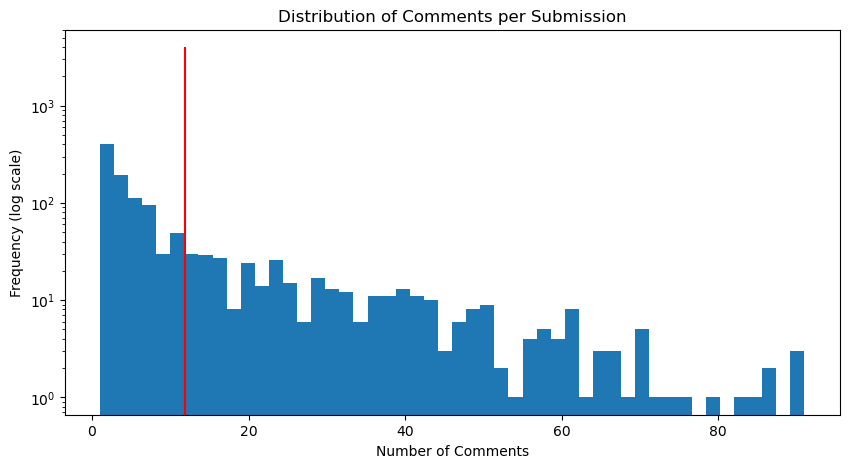

In [11]:
# Histogram
plt.figure(figsize=(10, 5))
plt.hist(relevant_submissions['count'], bins=50)
plt.vlines((relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4000)

plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Number of Comments")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Comments per Submission")
plt.show()


In [12]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,250,0.000000,2.397940
1,2,157,0.301030,2.195900
2,3,110,0.477121,2.041393
3,4,85,0.602060,1.929419
4,5,61,0.698970,1.785330
...,...,...,...,...
74,85,1,1.929419,0.000000
75,86,1,1.934498,0.000000
76,87,1,1.939519,0.000000
77,90,1,1.954243,0.000000


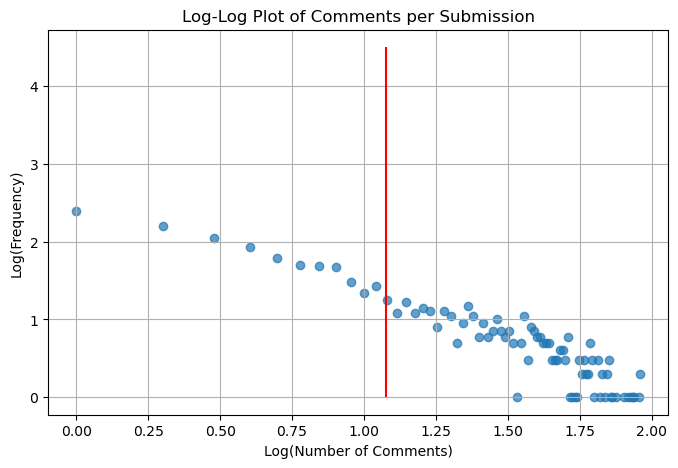

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Nr. of submissions')

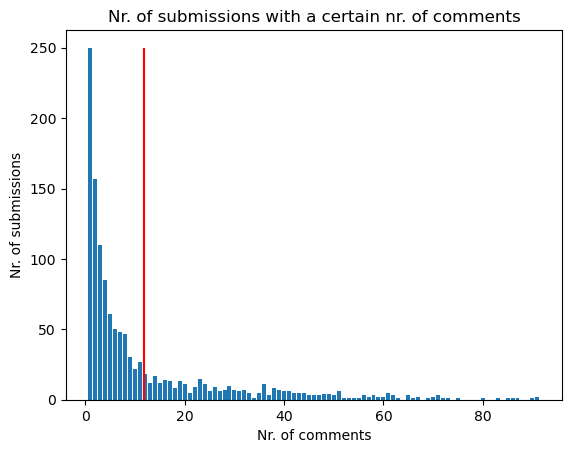

In [14]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['comment_count'], height = plt_data['class_count'])
plt.vlines(relevant_submissions['count'].mean(), colors="red", ymin = 0, ymax=250)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

Text(0, 0.5, 'Nr. of submissions')

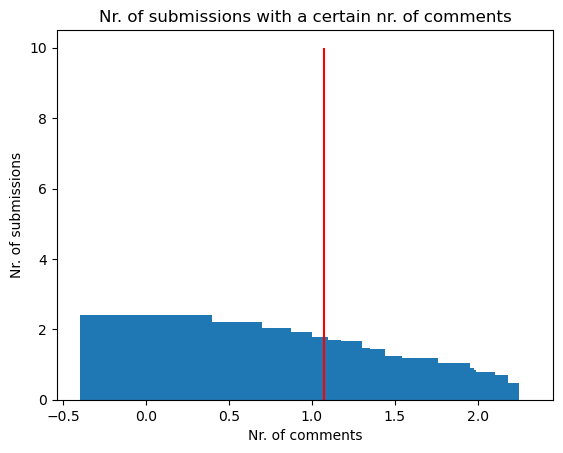

In [ ]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['log_com_count'], height = plt_data['log_class_count'])
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=10)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

In [16]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 11.886655948553054
Nr. of submission, that I have comments for 1244
All submissions found
Removing empty submissions deleted 528 submissions
Kept 716 submissions
Nr. of comments, whose submission is retaied 12750
Share 0.8622438628525055


In [17]:

print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

# roughly half

Number of relevant submissions: 716
Lost submissions:  665


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.252976e+09,9kkf8,2r73k,I don't know if it's entirely manufactured but...,9kkf8,c0d5jwa,c0d5jwa,6.0,6,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
1,jdoe2003,1.252978e+09,9kkf8,2r73k,I think most things in the media are manufactu...,9kkf8,c0d5m53,c0d5m53,3.0,3,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
2,newliberty,1.252996e+09,9kncm,2r73k,For what it's worth - Glenn Beck has been insu...,9kncm,c0d5zrm,c0d5zrm,3.0,3,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
3,bigstevec,1.253034e+09,9kkf8,2r73k,I don’t see it as a conspiracy on the left or ...,9kkf8,c0d6k0v,c0d6k0v,3.0,3,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
4,[deleted],1.253053e+09,9kkf8,2r73k,You haven't seen the polling? Look at the perc...,9kkf8,c0d71cb,c0d71cb,-1.0,-1,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-16,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12745,RickySlayer9,1.704063e+09,18ut80y,2r73k,Simply by people A) expressing disinterest and...,18ut80y,kfreg6m,kfreg6m,1.0,1,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment
12746,[deleted],1.704063e+09,18ut80y,2r73k,[removed],18ut80y,kfrg5x4,kfrg5x4,1.0,1,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment
12747,Adezar,1.704066e+09,18vgjif,2r73k,I really wish children were protected from rel...,18vgjif,kfrlxy0,kfrlxy0,2.0,2,0.0,PoliticalDebate,NaN,,False,True,NaN,2024-01-01,comment
12748,CFSCFjr,1.704066e+09,18vgjif,2r73k,The state should absolutely be doing more to e...,18vgjif,kfrmjm6,kfrmjm6,9.0,9,0.0,PoliticalDebate,NaN,,False,True,NaN,2024-01-01,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [19]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 10537
Nr. of unique comments 6337
Nr. of unique submissions 651


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5jwa,c0d5kfi,"I have a number of problems with Glenn Beck, b...",PoliticalDebate,1.252976e+09,tsoldrin,5.0,5,0.0,9kkf8,...,[deleted],6.0,6,0.0,1.252976e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
3,c0d5m53,c0d6jvc,"""Should have taken the blue pill.""\r\n\r\nFTFY",PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
4,c0d5zrm,c0d6nos,[deleted],PoliticalDebate,1.253038e+09,[deleted],2.0,2,0.0,9kncm,...,newliberty,3.0,3,0.0,1.252996e+09,Groupthink is a type of thought process in whi...,kmeisthax,NaN,7,1.252993e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10532,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09
10533,kfn0nkx,kfre8w0,[removed],PoliticalDebate,1.704063e+09,[deleted],1.0,1,0.0,18u79ir,...,nthlmkmnrg,1.0,1,0.0,1.703987e+09,Mark Cuban distancing himself from some of his...,Lorpedodontist,9.0,9,1.703912e+09
10534,kfrg5x4,kfrg5yp,Your comment was removed because you do not ha...,PoliticalDebate,1.704063e+09,AutoModerator,1.0,1,0.0,18ut80y,...,[deleted],1.0,1,0.0,1.704063e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09
10535,kfoqu1m,kfrgdfm,> *Libertarians tend to think we have enough t...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09


In [20]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [21]:
df_matched['body_child'].value_counts().head(10)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

body_child
Your comment was removed because you do not have a user flair. We require members to have a user flair to participate on this sub.\nFor instructions on how to add a user flair [click here](https://support.reddithelp.com/hc/en-us/articles/205242695-How-do-I-get-user-flair-#:~:text=On%20reddit.com,set%20it%20up%20for%20you) \n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/PoliticalDebate) if you have any questions or concerns.*    580
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [22]:
df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 392 interactions. Share:  0.037202239726677425
Kept 10145 interactions.
Deleting empty authors deleted 131 interactions. Share:  0.01291276490882208
Kept 10014 interactions.
Length 5 removes 696 interactions
Kept 9318 interactions
Drop duplicates (in parent & child text and author) removed 3 interactions. Share:  0.0003219575016097875
Kept 9315 interactions.
After text cleaning 3 interactions had empty texts and got removed. Share:  0.00032206119162640903
Kept 9312 interactions.


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6jvc,Should have taken the blue pill.\r \r FTFY,PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
3,c0d5zrm,c0d7f4g,I backed up Glenn Beck as long as I could but ...,PoliticalDebate,1.253072e+09,orblivion,1.0,1,0.0,9kncm,...,newliberty,3.0,3,0.0,1.252996e+09,Groupthink is a type of thought process in whi...,kmeisthax,NaN,7,1.252993e+09
4,c7fp9wr,c7fpb3l,I seem to notice that as well. It said the nam...,PoliticalDebate,1.355362e+09,ChurroMooCow,1.0,1,0.0,14r5kt,...,Trayf,2.0,2,0.0,1.355362e+09,Hi guys! I would like to proudly announce that...,ChurroMooCow,2.0,2,1.355356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,1.704058e+09,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,1.703983e+09,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,1.703967e+09
9308,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,1.704061e+09,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,1.704000e+09,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,1.703970e+09
9309,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09
9310,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09


In [23]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Save and export

In [24]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6jvc,Should have taken the blue pill.\r \r FTFY,PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
3,c0d5zrm,c0d7f4g,I backed up Glenn Beck as long as I could but ...,PoliticalDebate,1.253072e+09,orblivion,1.0,1,0.0,9kncm,...,newliberty,3.0,3,0.0,1.252996e+09,Groupthink is a type of thought process in whi...,kmeisthax,NaN,7,1.252993e+09
4,c7fp9wr,c7fpb3l,I seem to notice that as well. It said the nam...,PoliticalDebate,1.355362e+09,ChurroMooCow,1.0,1,0.0,14r5kt,...,Trayf,2.0,2,0.0,1.355362e+09,Hi guys! I would like to proudly announce that...,ChurroMooCow,2.0,2,1.355356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,1.704058e+09,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,1.703983e+09,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,1.703967e+09
9308,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,1.704061e+09,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,1.704000e+09,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,1.703970e+09
9309,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09
9310,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09


***
## **Descriptive Stats**

In [25]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

4151
Unique Users:  3727


### Time Stats and originally pulled counts

In [26]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2009-09-15
End of time frame: 2024-01-01
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 1381
Number of comments and replies: 93166
---------------------------------------------



### Descriptive Stats after Matching

In [27]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  10537
Number of unique comments:  6337
Number of unique submissions:  651


### Descriptive Stats after cleaning for high quality texts

In [28]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  9312
Unique Comments:  5761
Unique Submissions:  623


In [29]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  2449
